# Example: Reading raster data

This example illustrates the how to read raster data using the HydroMT [DataCatalog](../_generated/hydromt.data_catalog.DataCatalog.rst) with the `raster`, `netcdf` and `raster_tindex` drivers.

In [1]:
import hydromt

In [2]:
# Download artifacts for the Piave basin to `~/.hydromt_data/`.
data_catalog = hydromt.DataCatalog(data_libs=["artifact_data=v1.0.0"])

## Rasterio driver

To read raster data and parse it into a [xarray Dataset or DataArray](https://xarray.pydata.org/en/stable/user-guide/data-structures.html) we use the [get_rasterdataset()](../_generated/hydromt.data_catalog.DataCatalog.get_rasterdataset.rst) method. All `driver_kwargs` in the data catalog yaml file will be passed to this method. The `raster` driver supports all [GDAL data formats ](http://www.gdal.org/formats_list.html), including the often used GeoTiff of Cloud Optimized GeoTiff (COG) formats. Tiled datasets can also be passed as a [virtual raster tileset (vrt) file](https://gdal.org/drivers/raster/vrt.html). 

As an example we will use the [MERIT Hydro](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro) dataset which is a set of GeoTiff files with identical grids, one for each variable of the datasets. 

In [3]:
# inspect data source entry in data catalog yaml file
data_catalog.get_source("merit_hydro")

RasterDatasetSource(name='merit_hydro', uri='merit_hydro/{variable}.tif', data_adapter=RasterDatasetAdapter(unit_add={}, unit_mult={}, rename={}), driver=RasterioDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78f8800712e0>, options={}), uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78f8800712e0>, options={}), root='/home/sam/.hydromt/artifact_data/v1.0.0', version='1.0', provider=None, metadata=SourceMetadata(crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=None, attrs={}, category='topography', paper_doi='10.1029/2019WR024873', paper_ref='Yamazaki et al. (2019)', url='http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT

We can load any RasterDataset using [DataCatalog.get_rasterdataset()](../_generated/hydromt.data_catalog.DataCatalog.get_rasterdataset.rst). Note that if we don't provide any arguments it returns the full dataset with nine data variables and for the full spatial domain. Only the data coordinates are actually read, the data variables are still lazy [Dask arrays](https://docs.dask.org/en/stable/array.html).

In [4]:
ds = data_catalog.get_rasterdataset("merit_hydro")
ds

<xarray.Dataset> Size: 97MB
Dimensions:      (x: 1680, y: 1920)
Coordinates:
  * x            (x) float64 13kB 11.6 11.6 11.6 11.6 ... 13.0 13.0 13.0 13.0
  * y            (y) float64 15kB 46.8 46.8 46.8 46.8 ... 45.2 45.2 45.2 45.2
    spatial_ref  int64 8B 0
Data variables:
    lndslp       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    hnd          (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    strord       (y, x) uint8 3MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    upgrid       (y, x) int32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    basins       (y, x) uint32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    elevtn       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    rivwth       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    flwdir       (y, x) uint8 3MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    uparea       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
Attributes:
    crs:        4326
    category:   topography
    paper_doi:  10.1029/2019WR024873
    paper_ref:  Yamazaki et al. (2019)
    url:        http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro
    license:    CC-BY-NC 4.0 or ODbL 1.0

The data can be visualized with the [.plot()](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html) xarray method. We replace all nodata values with NaNs with [.raster.mask_nodata()](../_generated/hydromt.gis.DataArray.raster.mask_nodata.rst).

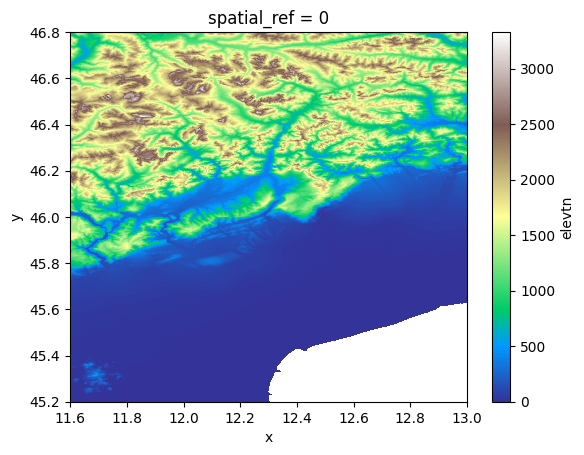

In [5]:
ds["elevtn"].raster.mask_nodata().plot(cmap="terrain")

We can request a (spatial) subset data by providing additional `variables` and `bbox` / `geom` arguments. Note that these return a smaller spatial extent and just two data variables. The variables argument is especially useful if each variable of the dataset is saved in a separate file and the `{variable}` key is used in the path argument of the data source (see above) to limit which files are actually read. If a single variable is requested a DataArray instead of a Dataset is returned unless the `single_var_as_array` argument is set to False (True by default).

In [6]:
bbox = [11.70, 45.35, 12.95, 46.70]
ds = data_catalog.get_rasterdataset(
    "merit_hydro", bbox=bbox, variables=["elevtn"], single_var_as_array=True
)
ds

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((12.95 45.35, 12.95 46.7, 11.7 46.7, ....


<xarray.DataArray 'elevtn' (y: 1620, x: 1500)> Size: 10MB
dask.array<getitem, shape=(1620, 1500), dtype=float32, chunksize=(1620, 1500), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 12kB 11.7 11.7 11.7 11.7 ... 12.95 12.95 12.95
  * y            (y) float64 13kB 46.7 46.7 46.7 46.7 ... 45.35 45.35 45.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    source_file:    elevtn.tif

TIP: To write a dataset back to a stack of raster in a single folder use the [.raster.to_mapstack()](../_generated/hydromt.gis.Dataset.raster.to_mapstack.rst) method.

## Xarray driver

Many gridded datasets with a third dimension (e.g. time) are saved in netcdf or zarr files, which can be read with Xarray. This data is read using the [xarray.open_mfdataset()](https://docs.xarray.dev/en/latest/generated/xarray.open_mfdataset.html) method. These formats are flexible and therefore 
HydroMT is not always able to read the geospatial attributes such as the CRS from the data and it has to be set through the data catalog [yaml file](../guides/advanced_user/data_prepare_cat.rst).

If the data is stored per year or month, the `{year}` and `{month}` keys can be used in the path argument of a data source in the data catalog yaml file to speed up the reading of a temporal subset of the data using the `date_tuple` argument of [DataCatalog.get_rasterdataset()](../_generated/hydromt.data_catalog.DataCatalog.get_rasterdataset.rst) (not in this example).

As example we use the [ERA5](https://doi.org/10.24381/cds.bd0915c6) dataset. 

In [7]:
# Note the crs argument as this is missing in the original data
data_catalog.get_source("era5_hourly")

RasterDatasetSource(name='era5_hourly', uri='era5_hourly.nc', data_adapter=RasterDatasetAdapter(unit_add={'temp': -273.15}, unit_mult={'kin': 0.000277778, 'kout': 0.000277778, 'precip': 1000, 'press_msl': 0.01}, rename={}), driver=RasterDatasetXarrayDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78f8800712e0>, options={}), uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78f8800712e0>, options={}), root='/home/sam/.hydromt/artifact_data/v1.0.0', version=None, provider=None, metadata=SourceMetadata(crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=None, attrs={}, category='meteo', history='Extracted from Copernicus Cli

In [8]:
# Note that the some units are converted
ds = data_catalog.get_rasterdataset("era5_hourly")
ds

object: RasterDatasetXarrayDriver does not use kwarg metadata with value crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 unit=None extent={} nodata=None attrs={} category='meteo' history='Extracted from Copernicus Climate Data Store' paper_doi='10.1002/qj.3803' paper_ref='Hersbach et al. (2019)' url='https://doi.org/10.24381/cds.bd0915c6' license='https://cds.climate.copernicus.eu/cdsapp/#!/terms/licence-to-use-copernicus-products'.


<xarray.Dataset> Size: 285kB
Dimensions:      (longitude: 6, latitude: 7, time: 336)
Coordinates:
  * longitude    (longitude) float32 24B 11.75 12.0 12.25 12.5 12.75 13.0
  * latitude     (latitude) float32 28B 46.75 46.5 46.25 46.0 45.75 45.5 45.25
  * time         (time) datetime64[ns] 3kB 2010-02-01 ... 2010-02-14T23:00:00
    spatial_ref  int32 4B ...
Data variables:
    press_msl    (time, latitude, longitude) float32 56kB dask.array<chunksize=(336, 7, 6), meta=np.ndarray>
    kin          (time, latitude, longitude) float32 56kB dask.array<chunksize=(336, 7, 6), meta=np.ndarray>
    temp         (time, latitude, longitude) float32 56kB dask.array<chunksize=(336, 7, 6), meta=np.ndarray>
    kout         (time, latitude, longitude) float32 56kB dask.array<chunksize=(336, 7, 6), meta=np.ndarray>
    precip       (time, latitude, longitude) float32 56kB dask.array<chunksize=(336, 7, 6), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.6
    history:         Extracted from Copernicus Climate Data Store
    category:        meteo
    paper_doi:       10.1002/qj.3803
    paper_ref:       Hersbach et al. (2019)
    source_license:  https://cds.climate.copernicus.eu/cdsapp/#!/terms/licenc...
    source_url:      https://doi.org/10.24381/cds.bd0915c6
    source_version:  ERA5 hourly data on pressure levels
    crs:             4326
    url:             https://doi.org/10.24381/cds.bd0915c6
    license:         https://cds.climate.copernicus.eu/cdsapp/#!/terms/licenc...

## Raster_tindex Resolver

If the raster data is tiled but for each tile a different CRS is used (for instance a different UTM projection for each UTM zone), this dataset cannot be described using a VRT file. In this case a vector file can be built to use a raster tile index using [gdaltindex](https://gdal.org/programs/gdaltindex.html). To read the data into a single `xarray.Dataset` the data needs to be reprojected and mosaicked to a single CRS while reading. As this type of data cannot be loaded lazily the method is typically used with an area of interest for which the data is loaded and combined. 

As example we use the [GRWL mask](https://doi.org/10.5281/zenodo.1297434) raster tiles for which we have created a tileindex using the aforementioned *gdaltindex* command line tool. Note that the path points to the GeoPackage output of the *gdaltindex* tool.

In [9]:
data_catalog.get_source("grwl_mask")

RasterDatasetSource(name='grwl_mask', uri='grwl_tindex.gpkg', data_adapter=RasterDatasetAdapter(unit_add={}, unit_mult={}, rename={}), driver=RasterioDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78f8800712e0>, options={'mosaic': True, 'chunks': {'x': 3000, 'y': 3000}, 'mosaic_kwargs': {'method': 'nearest'}}), uri_resolver=RasterTindexResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78f8800712e0>, options={'tileindex': 'location'}), root='/home/sam/.hydromt/artifact_data/v1.0.0', version='1.01', provider=None, metadata=SourceMetadata(crs=None, unit=None, extent={}, nodata=0, attrs={}, category=None, paper_doi='10.1126/science.aat0636', paper_ref='Allen and Pavelsky (2018)', url='https://doi.org/10.5281/zenodo.1297434', license='CC BY 4.0'))

In [10]:
# the tileindex is a GeoPackage vector file
# with an attribute column 'location' (see also the tileindex argument under driver_kwargs) containing the (relative) paths to the raster file data
import geopandas as gpd

tindex_path = data_catalog.get_source("grwl_mask").full_uri
print(tindex_path)
gpd.read_file(tindex_path, rows=5)

/home/sam/.hydromt/artifact_data/v1.0.0/grwl_tindex.gpkg


,location,EPSG,geometry
0,GRWL_mask_V01.01//NA17.tif,EPSG:32617,"POLYGON ((-80.92667 4.00635, -77.99333 4.00082..."
1,GRWL_mask_V01.01//NA18.tif,EPSG:32618,"POLYGON ((-78.00811 4.00082, -71.99333 4.00082..."
2,GRWL_mask_V01.01//NA19.tif,EPSG:32619,"POLYGON ((-72.00811 4.00082, -65.99333 4.00082..."
3,GRWL_mask_V01.01//NA20.tif,EPSG:32620,"POLYGON ((-66.00811 4.00082, -59.99333 4.00082..."
4,GRWL_mask_V01.01//NA21.tif,EPSG:32621,"POLYGON ((-60.00811 4.00082, -53.99333 4.00082..."


In [11]:
# this returns a DataArray (single variable) wit a mosaic of several files (see source_file attribute)
ds = data_catalog.get_rasterdataset("grwl_mask", bbox=bbox)
ds

<xarray.DataArray 'NL33' (y: 5108, x: 3393)> Size: 17MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y            (y) float64 41kB 5.177e+06 5.177e+06 ... 5.024e+06 5.024e+06
  * x            (x) float64 27kB 2.415e+05 2.415e+05 ... 3.432e+05 3.433e+05
    spatial_ref  int64 8B 0
Attributes:
    DataType:            Generic
    AREA_OR_POINT:       Area
    RepresentationType:  ATHEMATIC
    _FillValue:          0
    source_file:         NL33.tif; NL32.tif